# This notebook is to test python plotting .mat TTC files



In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from magic_formula import *
from ttc_utils import *
from scipy.optimize import curve_fit



# Wrapper function for easily displaying markdown text
disp_md = lambda text: display(Markdown(text))

## Plot MF52 with known parameters

https://fsaettc.org/viewtopic.php?t=117

[-0.28373, -13.162, -0.51324, 14.735, 1.022, -0.10564, -0.0015459, -1.1226, -78.793, 2.613, 0.69322, 0.0096093, 0.0034252, -0.23575, 0.058614, 0.03306, -5.3644, -0.95201, 300]


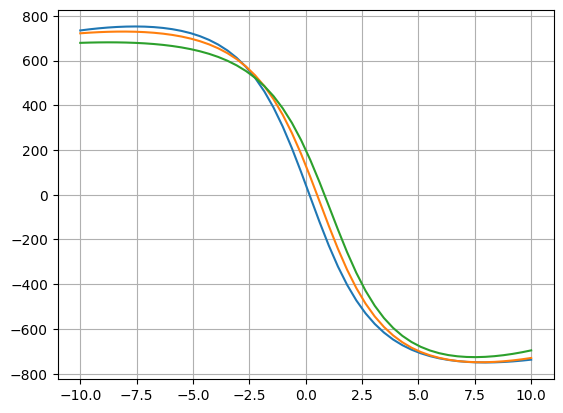

In [2]:
A1654raw6_12psi = {
    'PCY1' : -0.28373,
    'PDY1' : -13.162,
    'PDY2' : -0.51324,
    'PDY3' : 14.735,
    'PEY1' : 1.022,
    'PEY2' : -0.10564,
    'PEY3' : -0.0015459,
    'PEY4' : -1.1226,
    'PKY1' : -78.793,
    'PKY2' : 2.613,
    'PKY3' : 0.69322,
    'PHY1' : 0.0096093,
    'PHY2' : 0.0034252,
    'PHY3' : -0.23575,
    'PVY1' : 0.058614,
    'PVY2' : 0.03306,
    'PVY3' : -5.3644,
    'PVY4' : -0.95201,
}

slip_range = np.linspace(-10,10)
fz = 300

p = list(A1654raw6_12psi.values()) + [fz]
print(p)
#input_data = [(slip, fz, 0) for slip in slip_range]
plt.plot(slip_range, mf52_Fy((slip_range, fz, 0), p))
plt.plot(slip_range, mf52_Fy((slip_range, fz, -2), p))
plt.plot(slip_range, mf52_Fy((slip_range, fz, -4), p))

plt.grid()




In [3]:
#r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run5.mat')
r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run4.mat')

print(r2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AMBTMP', 'ET', 'FX', 'FY', 'FZ', 'IA', 'MX', 'MZ', 'N', 'NFX', 'NFY', 'P', 'RE', 'RL', 'RST', 'RUN', 'SA', 'SL', 'SR', 'TSTC', 'TSTI', 'TSTO', 'V', 'channel', 'source', 'testid', 'tireid'])


### Plot Full Run

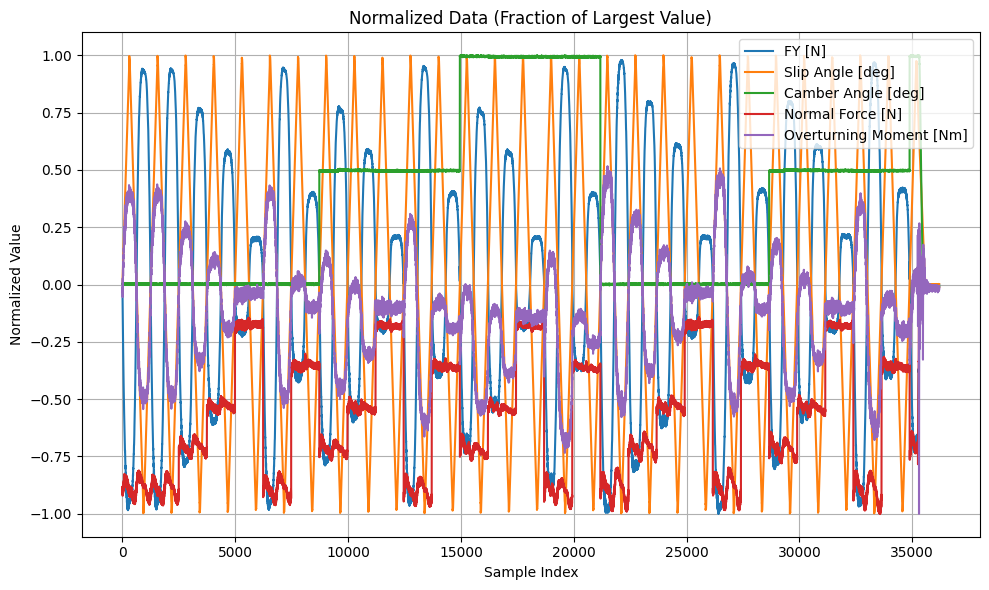

In [4]:
V = r2['V'].flatten()
SA = r2['SA'].flatten()
IA = r2['IA'].flatten()
FZ = r2['FZ'].flatten()
FY = r2['FY'].flatten()
MX = r2['MX'].flatten()

# Normalize all data as a fraction of their respective maximum absolute value
V_norm = V / np.max(np.abs(V)) if np.max(np.abs(V)) != 0 else V
SA_norm = SA / np.max(np.abs(SA)) if np.max(np.abs(SA)) != 0 else SA
IA_norm = IA / np.max(np.abs(IA)) if np.max(np.abs(IA)) != 0 else IA
FZ_norm = FZ / np.max(np.abs(FZ)) if np.max(np.abs(FZ)) != 0 else FZ
FY_norm = FY / np.max(np.abs(FY)) if np.max(np.abs(FY)) != 0 else FY
MX_norm = MX / np.max(np.abs(MX)) if np.max(np.abs(MX)) != 0 else MX


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(FY_norm, label='FY [N]')
ax.plot(SA_norm, label='Slip Angle [deg]')
ax.plot(IA_norm, label='Camber Angle [deg]')
ax.plot(FZ_norm, label='Normal Force [N]')
ax.plot(MX_norm, label='Overturning Moment [Nm]')

ax.set_title('Normalized Data (Fraction of Largest Value)')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Normalized Value')
ax.grid()
ax.legend()

fig.tight_layout()
plt.show()

### Fit MF5.2 lateral model

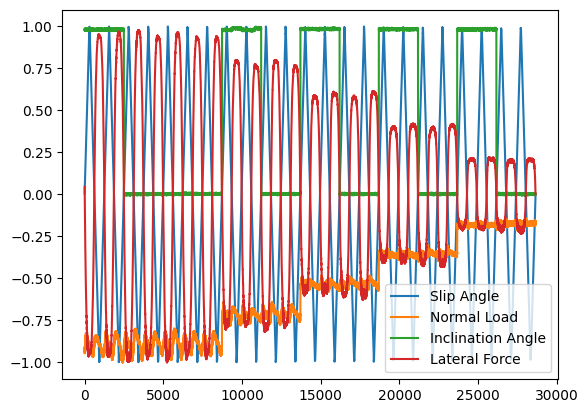

[-1.05464406e+00  6.05933570e+00  5.18215256e-01  1.62164421e+03
  2.55505000e-02  7.55884449e-03 -9.65809762e+04  7.74078285e+05
  6.12236554e+02 -2.83188589e+02 -3.57101929e+00 -9.68037380e-02
  1.88135611e-02  7.63835034e-02 -3.08032286e+00 -3.06713383e-01
  1.42491742e+00 -2.83090582e-01]


In [ ]:
inclination_steps = regroup_similar_steps(process_stepwise_data(IA, extr_data=[FZ, SA, FY]), rel_tol=0.05)
del inclination_steps[1]#removes the second camber step because it was garbage data
ia, fz, sa, fy = np.concatenate([[ia, fz, sa, fy] for camber_avg, (ia, fz, sa, fy) in inclination_steps], axis=1)

fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [ia, sa, fy]))
sa, fz, ia, fy = np.concatenate([[sa, fz, ia, fy] for camber_avg, (fz, ia, sa, fy) in fz_steps], axis=1)

plt.plot(sa/np.max(np.abs(sa)), label = 'Slip Angle')
plt.plot(fz/np.max(np.abs(fz)), label = 'Normal Load')
plt.plot(ia/np.max(np.abs(ia)), label = 'Inclination Angle')
plt.plot(fy/np.max(np.abs(fy)), label = 'Lateral Force')
plt.legend()
plt.show()


fz0 = 700

xdata = (-sa, fz, ia)
popt, pcov = curve_fit(lambda x, p_cy1, p_dy1, p_dy2, p_dy3, p_ey1, p_ey2, p_ey3, p_ey4, p_ky1, p_ky2, p_ky3, p_hy1, p_hy2, p_hy3, p_vy1, p_vy2, p_vy3, p_vy4: 
                    mf52_Fy(x, [p_cy1, p_dy1, p_dy2, p_dy3, p_ey1, p_ey2, p_ey3, p_ey4, p_ky1, p_ky2, p_ky3, p_hy1, p_hy2, p_hy3, p_vy1, p_vy2, p_vy3, p_vy4, fz0]), 
                    xdata, 
                    -fy,
                    maxfev = 500000)

print(popt)


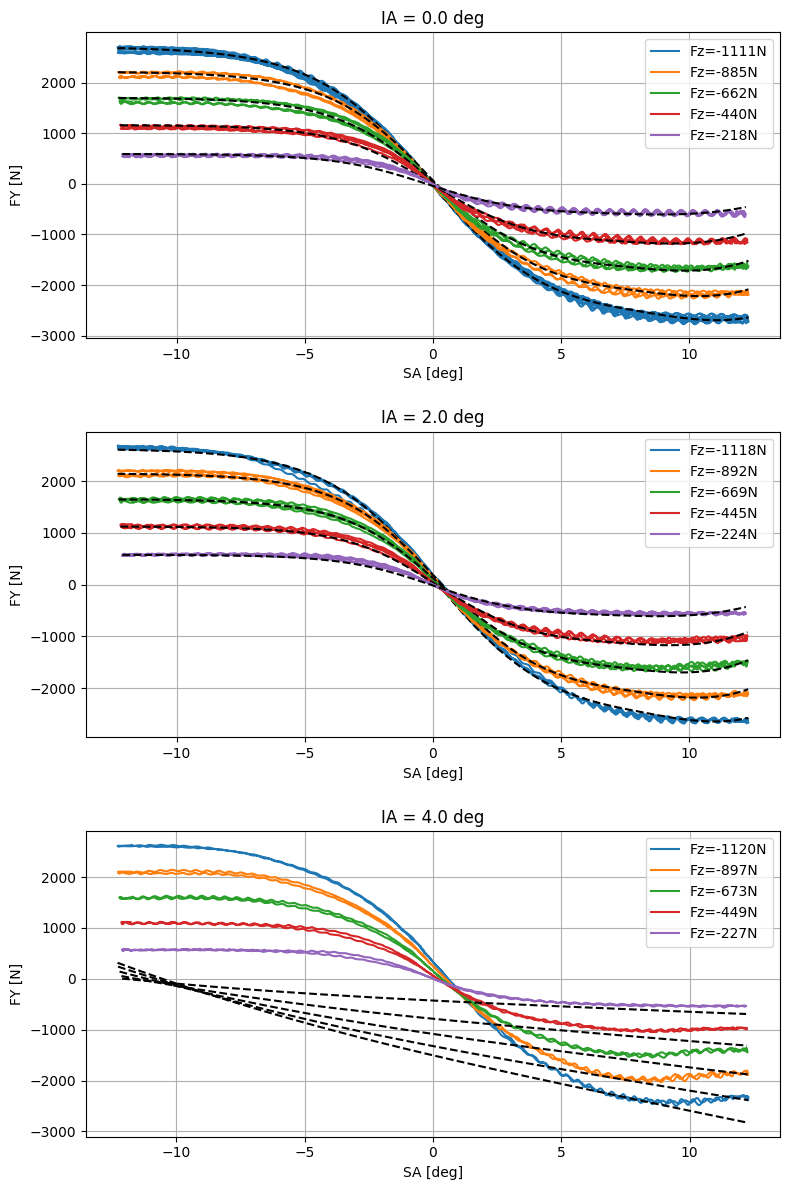

In [6]:
import numpy as np




fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax = ax.flatten()
for i, c_step in enumerate(inclination_steps):
    incl_avg, (ia, fz, sa, fy) = c_step

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    for step in fz_steps:
        fz_avg, (fz, sa, fy) = step
        ax[i].plot(sa, fy, label = f"Fz={fz_avg:.0f}N")
        
        # Plot fitted curve using matplotlib's plot
        sa_fit = np.linspace(np.min(sa), np.max(sa), 100)
        fy_fit = -mf52_Fy((-sa_fit, -fz_avg, incl_avg), list(popt) + [fz0])
        ax[i].plot(sa_fit, fy_fit, '--', color = 'black')

    ax[i].set_title(f'IA = {incl_avg:.1f} deg')
    ax[i].set_xlabel('SA [deg]')
    ax[i].set_ylabel('FY [N]')
    ax[i].grid()
    ax[i].legend()


fig.tight_layout(h_pad=2)
plt.show()